In [1]:
import glob
import os
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
import time
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.models import load_model
import natsort

In [2]:
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())
physical_gpu = tf.config.list_physical_devices('GPU')
print(len(physical_gpu))

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10650010381036086076
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 10460092937261514942
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3049888155
locality {
  bus_id: 1
  links {
  }
}
incarnation: 382379048900349362
physical_device_desc: "device: 0, name: GeForce GTX 1650, pci bus id: 0000:08:00.0, compute capability: 7.5"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 16791847361770853038
physical_device_desc: "device: XLA_GPU device"
]
1


In [3]:
# MLP
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
# dt
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score
import pydotplus
from sklearn.tree import export_graphviz
from IPython.core.display import Image

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# SVM
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC, SVC
from sklearn.preprocessing import PolynomialFeatures

# rf
from sklearn.ensemble import RandomForestClassifier

In [4]:
seed = 0
tf.random.set_seed(seed)

model_metrics = 'acc'    # acc, mse, mae (epoch마다 표시)
num_epochs = 10
num_batch = 100
num_split = 0.2

In [5]:
H_path= 'D:/sensors journal/TT_H/train/existing/txt'
H_files = glob.glob(os.path.join(H_path, "*.txt"))
H_files = natsort.natsorted(H_files)
print(H_files)
H_each_file = (pd.read_csv(f, header=None, sep = "\t") for f in H_files)

['D:/sensors journal/TT_H/train/existing/txt\\1.txt', 'D:/sensors journal/TT_H/train/existing/txt\\2.txt', 'D:/sensors journal/TT_H/train/existing/txt\\3.txt', 'D:/sensors journal/TT_H/train/existing/txt\\4.txt', 'D:/sensors journal/TT_H/train/existing/txt\\5.txt', 'D:/sensors journal/TT_H/train/existing/txt\\6.txt', 'D:/sensors journal/TT_H/train/existing/txt\\7.txt', 'D:/sensors journal/TT_H/train/existing/txt\\8.txt', 'D:/sensors journal/TT_H/train/existing/txt\\9.txt', 'D:/sensors journal/TT_H/train/existing/txt\\10.txt', 'D:/sensors journal/TT_H/train/existing/txt\\11.txt', 'D:/sensors journal/TT_H/train/existing/txt\\12.txt', 'D:/sensors journal/TT_H/train/existing/txt\\13.txt', 'D:/sensors journal/TT_H/train/existing/txt\\14.txt', 'D:/sensors journal/TT_H/train/existing/txt\\15.txt', 'D:/sensors journal/TT_H/train/existing/txt\\16.txt', 'D:/sensors journal/TT_H/train/existing/txt\\17.txt', 'D:/sensors journal/TT_H/train/existing/txt\\18.txt', 'D:/sensors journal/TT_H/train/exist

In [6]:
#test 데이터
test_H_path= 'D:/sensors journal/TT_H/test/existing/txt'
test_H_files = glob.glob(os.path.join(test_H_path, "*.txt"))
test_H_files = natsort.natsorted(test_H_files)
print(test_H_files)
test_H_each_file = (pd.read_csv(f, header=None, sep = "\t") for f in test_H_files)

['D:/sensors journal/TT_H/test/existing/txt\\1.txt', 'D:/sensors journal/TT_H/test/existing/txt\\2.txt', 'D:/sensors journal/TT_H/test/existing/txt\\3.txt', 'D:/sensors journal/TT_H/test/existing/txt\\4.txt', 'D:/sensors journal/TT_H/test/existing/txt\\5.txt', 'D:/sensors journal/TT_H/test/existing/txt\\6.txt', 'D:/sensors journal/TT_H/test/existing/txt\\7.txt', 'D:/sensors journal/TT_H/test/existing/txt\\8.txt', 'D:/sensors journal/TT_H/test/existing/txt\\9.txt', 'D:/sensors journal/TT_H/test/existing/txt\\10.txt', 'D:/sensors journal/TT_H/test/existing/txt\\11.txt', 'D:/sensors journal/TT_H/test/existing/txt\\12.txt', 'D:/sensors journal/TT_H/test/existing/txt\\13.txt', 'D:/sensors journal/TT_H/test/existing/txt\\14.txt', 'D:/sensors journal/TT_H/test/existing/txt\\15.txt', 'D:/sensors journal/TT_H/test/existing/txt\\16.txt', 'D:/sensors journal/TT_H/test/existing/txt\\17.txt', 'D:/sensors journal/TT_H/test/existing/txt\\18.txt', 'D:/sensors journal/TT_H/test/existing/txt\\19.txt', '

In [7]:
#class별 비율 확인 
H_file_list = list(H_each_file)
print(H_file_list)

[        0    1   2       3    4       5    6    7       8       9       10  \
0     0.50  1.0   1  0.3333  0.5  1.0000  0.0  1.0  0.3333  0.0000  0.3175   
1     0.50  0.5   0  0.5000  1.0  0.0606  1.0  1.0  0.3333  0.0000  0.3175   
2     0.50  1.0   0  0.3333  1.0  1.0000  1.0  1.0  0.3333  0.3333  0.3175   
3     0.50  0.5   0  0.8000  1.0  0.0606  0.5  1.0  0.3333  0.0000  0.3175   
4     0.75  1.0   0  0.3333  0.5  0.9848  1.0  1.0  0.3333  0.0000  0.3175   
...    ...  ...  ..     ...  ...     ...  ...  ...     ...     ...     ...   
5296  0.50  0.0   1  0.5000  1.0  0.7273  1.0  1.0  0.3333  0.0000  0.6349   
5297  0.50  0.0   1  0.6667  0.5  0.7576  1.0  1.0  0.3333  0.0000  0.6349   
5298  0.50  0.5   1  0.6667  0.5  0.7424  1.0  1.0  0.3333  0.0000  0.6349   
5299  0.50  0.0   0  0.5000  1.0  1.0000  0.0  1.0  1.0000  0.0000  0.6349   
5300  0.50  1.0   0  0.6667  0.5  1.0000  1.0  1.0  0.3333  0.3333  0.6349   

      11  12  
0      1   0  
1      1   0  
2      1   0  
3 

In [8]:
#class별 비율 확인 
test_H_file_list = list(test_H_each_file)
print(test_H_file_list)

[          0    1   2       3    4       5    6    7       8       9       10  \
0       0.50  0.0   0  0.5000  1.0  0.7273  1.0  1.0  0.3333  0.1667  0.3175   
1       0.75  0.0   0  0.5000  0.0  1.0000  1.0  1.0  0.3333  0.0000  0.3175   
2       0.50  0.0   0  0.6667  0.5  0.4242  1.0  0.5  0.3333  0.1667  0.3175   
3       0.50  1.0   0  0.5000  1.0  0.9848  1.0  1.0  0.3333  0.0000  0.3175   
4       0.50  0.5   1  0.6667  0.5  0.7273  1.0  1.0  0.3333  0.0000  0.3175   
...      ...  ...  ..     ...  ...     ...  ...  ...     ...     ...     ...   
107200  0.50  0.5   1  0.6667  0.5  1.0000  1.0  1.0  0.3333  0.3333  0.6349   
107201  0.50  0.0   1  0.3333  0.5  1.0000  1.0  1.0  0.3333  0.0000  0.6349   
107202  0.50  0.0   0  0.5000  0.0  1.0000  1.0  1.0  0.3333  0.3333  0.6349   
107203  0.50  0.0   0  0.3333  0.5  0.5606  1.0  1.0  0.3333  0.0000  0.6349   
107204  0.50  0.0   1  0.5000  0.0  0.5455  1.0  1.0  0.3333  0.0000  0.6349   

        11  12  
0        1   0  
1   

In [9]:
#subsampling x
input_num = 12
df = pd.DataFrame()
for data in H_file_list:
    df_class0 = data[data[input_num]==0]
    print("0: ", len(df_class0))
    df_class1 = data[data[input_num]==1]
    print("1: ", len(df_class1))
    df = pd.concat([df, df_class0, df_class1], ignore_index = True)
    print("concat: ", len(df), '\n')

0:  4368
1:  933
concat:  5301 

0:  10181
1:  1500
concat:  16982 

0:  5098
1:  759
concat:  22839 

0:  3025
1:  453
concat:  26317 

0:  15434
1:  1772
concat:  43523 

0:  1417
1:  151
concat:  45091 

0:  3557
1:  605
concat:  49253 

0:  2146
1:  413
concat:  51812 

0:  1435
1:  284
concat:  53531 

0:  3739
1:  564
concat:  57834 

0:  5419
1:  1092
concat:  64345 

0:  15407
1:  2375
concat:  82127 

0:  6721
1:  789
concat:  89637 

0:  3556
1:  389
concat:  93582 

0:  25284
1:  3221
concat:  122087 

0:  2649
1:  281
concat:  125017 

0:  5155
1:  734
concat:  130906 

0:  1902
1:  341
concat:  133149 

0:  2401
1:  336
concat:  135886 

0:  4088
1:  484
concat:  140458 

0:  5345
1:  1035
concat:  146838 

0:  15416
1:  2622
concat:  164876 

0:  7762
1:  974
concat:  173612 

0:  3555
1:  352
concat:  177519 

0:  26881
1:  3239
concat:  207639 

0:  1623
1:  178
concat:  209440 

0:  6348
1:  1088
concat:  216876 

0:  3325
1:  614
concat:  220815 

0:  2884
1:  407
con

concat:  3589298 

0:  6623
1:  541
concat:  3596462 

0:  7079
1:  652
concat:  3604193 

0:  10777
1:  906
concat:  3615876 

0:  5911
1:  325
concat:  3622112 

0:  16977
1:  2695
concat:  3641784 

0:  10429
1:  2020
concat:  3654233 

0:  31679
1:  4301
concat:  3690213 

0:  7667
1:  738
concat:  3698618 

0:  4051
1:  596
concat:  3703265 

0:  20323
1:  3561
concat:  3727149 

0:  2850
1:  333
concat:  3730332 

0:  49349
1:  5310
concat:  3784991 

0:  18654
1:  3163
concat:  3806808 

0:  38482
1:  5677
concat:  3850967 

0:  17688
1:  1876
concat:  3870531 

0:  28418
1:  2918
concat:  3901867 

0:  25672
1:  2497
concat:  3930036 

0:  14910
1:  2678
concat:  3947624 

0:  4090
1:  391
concat:  3952105 

0:  3247
1:  340
concat:  3955692 

0:  3808
1:  191
concat:  3959691 

0:  8506
1:  505
concat:  3968702 

0:  3777
1:  400
concat:  3972879 

0:  5018
1:  835
concat:  3978732 

0:  5371
1:  818
concat:  3984921 

0:  12020
1:  685
concat:  3997626 

0:  53442
1:  6279
co

In [10]:
#subsampling
test_df = pd.DataFrame()
for data in test_H_file_list:
    df_class0 = data[data[input_num]==0]
    print("0: ", len(df_class0))
    df_class1 = data[data[input_num]==1]
    print("1: ", len(df_class1))
    test_df = pd.concat([test_df, df_class0, df_class1], ignore_index = True)
    print("concat: ", len(test_df), '\n')

0:  92945
1:  14260
concat:  107205 

0:  2491
1:  564
concat:  110260 

0:  9472
1:  2450
concat:  122182 

0:  7750
1:  1991
concat:  131923 

0:  26492
1:  6328
concat:  164743 

0:  2230
1:  622
concat:  167595 

0:  2646
1:  661
concat:  170902 

0:  40727
1:  8798
concat:  220427 

0:  132282
1:  14669
concat:  367378 

0:  9998
1:  3592
concat:  380968 

0:  9159
1:  2275
concat:  392402 

0:  1865
1:  697
concat:  394964 

0:  38025
1:  9605
concat:  442594 

0:  94108
1:  10817
concat:  547519 

0:  118933
1:  22124
concat:  688576 

0:  35063
1:  1124
concat:  724763 

0:  15334
1:  3063
concat:  743160 

0:  10751
1:  1506
concat:  755417 

0:  11054
1:  1796
concat:  768267 

0:  35538
1:  5375
concat:  809180 

0:  14239
1:  2471
concat:  825890 

0:  64250
1:  6549
concat:  896689 



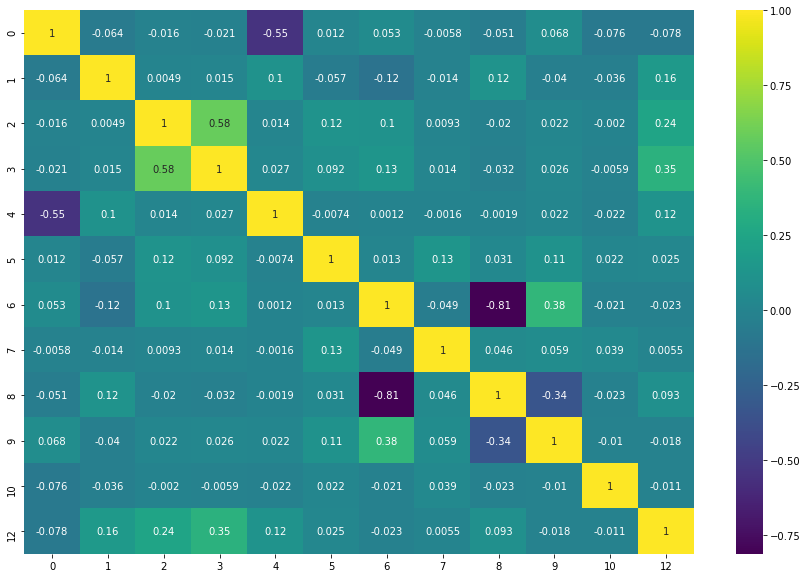

In [11]:
import seaborn as sns
df = df.drop([df.columns[11]], axis = 1)
plt.figure(figsize = (15, 10))
corr = df.corr()
#print(corr)
sns.heatmap(corr, cmap = 'viridis', annot = True)
plt.show()

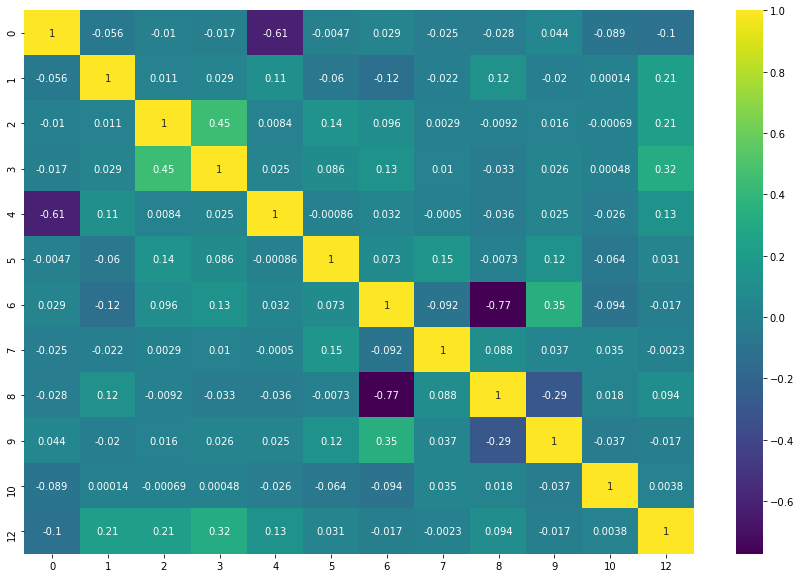

In [12]:
import seaborn as sns
test_df = test_df.drop([test_df.columns[11]], axis = 1)
plt.figure(figsize = (15, 10))
corr = test_df.corr()
#print(corr)
sns.heatmap(corr, cmap = 'viridis', annot = True)
plt.show()

In [13]:
df = df.to_numpy() 

In [14]:
test_df = test_df.to_numpy() 

In [15]:
# new
inp_num = 11
x = df[:, 0:inp_num]
y = df[:, inp_num]
X_train, X_val, Y_train, Y_val = train_test_split(x, y, test_size=0.2, stratify=y, random_state=seed)

In [16]:
# test
x_test = test_df[:, 0:inp_num]
y_test = test_df[:, inp_num]

In [17]:
# DT - depth 5

start = time.time() 

dt_depth5 = DecisionTreeClassifier(max_depth=5, min_samples_leaf=5, random_state=seed)
dt_depth5.fit(x, y)

print("훈련 세트 정확도: {:.3f}".format(dt_depth5.score(x, y)))
pred_dt = dt_depth5.predict(x_test)
accuracy_dt = []

accuracy_dt.append(accuracy_score(y_test, pred_dt))

print('Accuracy: %.4f' % accuracy_dt[0])
print("time :", time.time() - start)

print("\nfeature importance: \n{}".format(dt_depth5.feature_importances_))
del pred_dt

훈련 세트 정확도: 0.892
Accuracy: 0.8666
time : 31.096969604492188

feature importance: 
[0.         0.16158345 0.02940566 0.71577432 0.01746054 0.
 0.0223715  0.         0.05198543 0.         0.00141911]


In [18]:
dot_data = export_graphviz(dt_depth5, out_file=None, filled=True, rounded=True, special_characters=True, class_names=["0","1"])
graph = pydotplus.graph_from_dot_data(dot_data)
graph.write_png('existing_dt_depth5_org.png')

True

In [19]:
# DT - depth 6

start = time.time() 

dt_depth6 = DecisionTreeClassifier(max_depth=6, min_samples_leaf=5, random_state=seed)
dt_depth6.fit(x, y)
print("훈련 세트 정확도: {:.3f}".format(dt_depth6.score(x, y)))

pred_dt = dt_depth6.predict(x_test)
accuracy_dt.append(accuracy_score(y_test, pred_dt))

print('Accuracy: %.4f' % accuracy_dt[1])
print("time :", time.time() - start)

print("\nfeature importance: \n{}".format(dt_depth6.feature_importances_))
del pred_dt

훈련 세트 정확도: 0.892
Accuracy: 0.8677
time : 29.394588708877563

feature importance: 
[8.48058637e-04 1.56453907e-01 3.14130009e-02 6.95118403e-01
 2.21397048e-02 5.22115872e-03 3.64729182e-02 0.00000000e+00
 5.03211803e-02 4.03685516e-04 1.60798294e-03]


In [20]:
dot_data = export_graphviz(dt_depth6, out_file=None, filled=True, rounded=True, special_characters=True, class_names=["0","1"])
graph = pydotplus.graph_from_dot_data(dot_data)
graph.write_png('existing_dt_depth6_org.png')

True

In [21]:
# DT - depth 7

start = time.time() 

dt_depth7 = DecisionTreeClassifier(max_depth=7, min_samples_leaf=5, random_state=seed)
dt_depth7.fit(x, y)
print("훈련 세트 정확도: {:.3f}".format(dt_depth7.score(x, y)))

pred_dt = dt_depth7.predict(x_test)
accuracy_dt.append(accuracy_score(y_test, pred_dt))

print('Accuracy: %.4f' % accuracy_dt[2])
print("time :", time.time() - start)

print("\nfeature importance: \n{}".format(dt_depth7.feature_importances_))
del pred_dt

훈련 세트 정확도: 0.892
Accuracy: 0.8685
time : 32.271233558654785

feature importance: 
[0.00091314 0.15314609 0.03179724 0.68047579 0.02234104 0.01382394
 0.04305663 0.         0.04997928 0.00110533 0.00336151]


In [22]:
dot_data = export_graphviz(dt_depth7, out_file=None, filled=True, rounded=True, special_characters=True, class_names=["0","1"])
graph = pydotplus.graph_from_dot_data(dot_data)
graph.write_png('existing_dt_depth7_org.png')

True

In [23]:
#Test Accuracy 22개 영상, subsampling x
i=1
input_num = 12
for data in  test_H_file_list:
    each_test_df = pd.DataFrame()
    df_class0 = data[data[input_num]==0]
    print("0: ", len(df_class0))
    df_class1 = data[data[input_num]==1]
    print("1: ", len(df_class1))
    each_test_df = pd.concat([each_test_df, df_class0, df_class1], ignore_index = True)
    print("concat: ", len(each_test_df), '\n')
    each_test_df = each_test_df.drop([each_test_df.columns[11]], axis = 1)
    each_test_df = each_test_df.to_numpy()
    new_inp_num = 11
    each_x_test = each_test_df[:, 0:new_inp_num]
    each_y_test = each_test_df[:, new_inp_num]
    each_pred_dt = dt_depth7.predict(each_x_test)
    evaluation_accuracy = accuracy_score(each_y_test, each_pred_dt) 
    print(str(i)+". "+'Accuracy: %.4f\n' % evaluation_accuracy)
    i=i+1
    del each_pred_dt

0:  92945
1:  14260
concat:  107205 

1. Accuracy: 0.8687

0:  2491
1:  564
concat:  3055 

2. Accuracy: 0.8262

0:  9472
1:  2450
concat:  11922 

3. Accuracy: 0.8097

0:  7750
1:  1991
concat:  9741 

4. Accuracy: 0.8099

0:  26492
1:  6328
concat:  32820 

5. Accuracy: 0.8124

0:  2230
1:  622
concat:  2852 

6. Accuracy: 0.8015

0:  2646
1:  661
concat:  3307 

7. Accuracy: 0.8137

0:  40727
1:  8798
concat:  49525 

8. Accuracy: 0.8315

0:  132282
1:  14669
concat:  146951 

9. Accuracy: 0.9008

0:  9998
1:  3592
concat:  13590 

10. Accuracy: 0.7552

0:  9159
1:  2275
concat:  11434 

11. Accuracy: 0.8154

0:  1865
1:  697
concat:  2562 

12. Accuracy: 0.7490

0:  38025
1:  9605
concat:  47630 

13. Accuracy: 0.8129

0:  94108
1:  10817
concat:  104925 

14. Accuracy: 0.8991

0:  118933
1:  22124
concat:  141057 

15. Accuracy: 0.8445

0:  35063
1:  1124
concat:  36187 

16. Accuracy: 0.9684

0:  15334
1:  3063
concat:  18397 

17. Accuracy: 0.8444

0:  10751
1:  1506
concat:  12

In [24]:
# DT - depth 8

start = time.time() 

dt_depth8 = DecisionTreeClassifier(max_depth=8, min_samples_leaf=5, random_state=seed)
dt_depth8.fit(x, y)
print("훈련 세트 정확도: {:.3f}".format(dt_depth8.score(x, y)))

pred_dt = dt_depth8.predict(x_test)
accuracy_dt.append(accuracy_score(y_test, pred_dt))

print('Accuracy: %.4f' % accuracy_dt[3])
print("time :", time.time() - start)

print("\nfeature importance: \n{}".format(dt_depth8.feature_importances_))
del pred_dt

훈련 세트 정확도: 0.893
Accuracy: 0.8691
time : 35.756014585494995

feature importance: 
[1.04869758e-03 1.51050901e-01 3.22145353e-02 6.69385345e-01
 2.20636995e-02 2.11494261e-02 4.47263401e-02 6.60460703e-06
 5.06572639e-02 2.47456149e-03 5.22262602e-03]


In [25]:
dot_data = export_graphviz(dt_depth8, out_file=None, filled=True, rounded=True, special_characters=True, class_names=["0","1"])
graph = pydotplus.graph_from_dot_data(dot_data)
graph.write_png('existing_dt_depth8_org.png')

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.766211 to fit



True

In [26]:
#Test Accuracy 22개 영상, subsampling x
i=1
for data in  test_H_file_list:
    each_test_df = pd.DataFrame()
    df_class0 = data[data[input_num]==0]
    print("0: ", len(df_class0))
    df_class1 = data[data[input_num]==1]
    print("1: ", len(df_class1))
    each_test_df = pd.concat([each_test_df, df_class0, df_class1], ignore_index = True)
    print("concat: ", len(each_test_df), '\n')
    each_test_df = each_test_df.drop([each_test_df.columns[11]], axis = 1)
    each_test_df = each_test_df.to_numpy()
    new_inp_num = 11
    each_x_test = each_test_df[:, 0:new_inp_num]
    each_y_test = each_test_df[:, new_inp_num]
    each_pred_dt = dt_depth8.predict(each_x_test)
    evaluation_accuracy = accuracy_score(each_y_test, each_pred_dt) 
    print(str(i)+". "+'Accuracy: %.4f\n' % evaluation_accuracy)
    i=i+1
    del each_pred_dt

0:  92945
1:  14260
concat:  107205 

1. Accuracy: 0.8687

0:  2491
1:  564
concat:  3055 

2. Accuracy: 0.8242

0:  9472
1:  2450
concat:  11922 

3. Accuracy: 0.8088

0:  7750
1:  1991
concat:  9741 

4. Accuracy: 0.8079

0:  26492
1:  6328
concat:  32820 

5. Accuracy: 0.8146

0:  2230
1:  622
concat:  2852 

6. Accuracy: 0.8022

0:  2646
1:  661
concat:  3307 

7. Accuracy: 0.8161

0:  40727
1:  8798
concat:  49525 

8. Accuracy: 0.8307

0:  132282
1:  14669
concat:  146951 

9. Accuracy: 0.9011

0:  9998
1:  3592
concat:  13590 

10. Accuracy: 0.7536

0:  9159
1:  2275
concat:  11434 

11. Accuracy: 0.8153

0:  1865
1:  697
concat:  2562 

12. Accuracy: 0.7467

0:  38025
1:  9605
concat:  47630 

13. Accuracy: 0.8123

0:  94108
1:  10817
concat:  104925 

14. Accuracy: 0.8999

0:  118933
1:  22124
concat:  141057 

15. Accuracy: 0.8467

0:  35063
1:  1124
concat:  36187 

16. Accuracy: 0.9686

0:  15334
1:  3063
concat:  18397 

17. Accuracy: 0.8427

0:  10751
1:  1506
concat:  12

In [27]:
# DT - depth 9

start = time.time() 

dt_depth9 = DecisionTreeClassifier(max_depth=9, min_samples_leaf=5, random_state=seed)
dt_depth9.fit(x, y)
print("훈련 세트 정확도: {:.3f}".format(dt_depth9.score(x, y)))

pred_dt = dt_depth9.predict(x_test)
accuracy_dt.append(accuracy_score(y_test, pred_dt))

print('Accuracy: %.4f' % accuracy_dt[4])
print("time :", time.time() - start)

print("\nfeature importance: \n{}".format(dt_depth9.feature_importances_))
del pred_dt

훈련 세트 정확도: 0.893
Accuracy: 0.8691
time : 37.704450845718384

feature importance: 
[2.05804439e-03 1.49487355e-01 3.25007203e-02 6.62240145e-01
 2.23713010e-02 2.51898387e-02 4.48031604e-02 3.34329012e-05
 5.01283802e-02 4.33818543e-03 6.84943614e-03]


In [36]:
#Test Accuracy 22개 영상, subsampling x
i=1
for data in  test_H_file_list:
    each_test_df = pd.DataFrame()
    df_class0 = data[data[input_num]==0]
    print("0: ", len(df_class0))
    df_class1 = data[data[input_num]==1]
    print("1: ", len(df_class1))
    each_test_df = pd.concat([each_test_df, df_class0, df_class1], ignore_index = True)
    print("concat: ", len(each_test_df), '\n')
    each_test_df = each_test_df.drop([each_test_df.columns[11]], axis = 1)
    each_test_df = each_test_df.to_numpy()
    new_inp_num = 11
    each_x_test = each_test_df[:, 0:new_inp_num]
    each_y_test = each_test_df[:, new_inp_num]
    each_pred_dt = dt_depth9.predict(each_x_test)
    evaluation_accuracy = accuracy_score(each_y_test, each_pred_dt) 
    print(str(i)+". "+'Accuracy: %.4f\n' % evaluation_accuracy)
    i=i+1
    del each_pred_dt

0:  92945
1:  14260
concat:  107205 

1. Accuracy: 0.8692

0:  2491
1:  564
concat:  3055 

2. Accuracy: 0.8223

0:  9472
1:  2450
concat:  11922 

3. Accuracy: 0.8095

0:  7750
1:  1991
concat:  9741 

4. Accuracy: 0.8069

0:  26492
1:  6328
concat:  32820 

5. Accuracy: 0.8142

0:  2230
1:  622
concat:  2852 

6. Accuracy: 0.8008

0:  2646
1:  661
concat:  3307 

7. Accuracy: 0.8174

0:  40727
1:  8798
concat:  49525 

8. Accuracy: 0.8303

0:  132282
1:  14669
concat:  146951 

9. Accuracy: 0.9015

0:  9998
1:  3592
concat:  13590 

10. Accuracy: 0.7516

0:  9159
1:  2275
concat:  11434 

11. Accuracy: 0.8138

0:  1865
1:  697
concat:  2562 

12. Accuracy: 0.7459

0:  38025
1:  9605
concat:  47630 

13. Accuracy: 0.8106

0:  94108
1:  10817
concat:  104925 

14. Accuracy: 0.9001

0:  118933
1:  22124
concat:  141057 

15. Accuracy: 0.8472

0:  35063
1:  1124
concat:  36187 

16. Accuracy: 0.9686

0:  15334
1:  3063
concat:  18397 

17. Accuracy: 0.8411

0:  10751
1:  1506
concat:  12

In [28]:
# DT - depth 10

start = time.time() 

dt_depth10 = DecisionTreeClassifier(max_depth=10, min_samples_leaf=5, random_state=seed)
dt_depth10.fit(x, y)
print("훈련 세트 정확도: {:.3f}".format(dt_depth10.score(x, y)))

pred_dt = dt_depth10.predict(x_test)
accuracy_dt.append(accuracy_score(y_test, pred_dt))

print('Accuracy: %.4f' % accuracy_dt[5])
print("time :", time.time() - start)

print("\nfeature importance: \n{}".format(dt_depth10.feature_importances_))
del pred_dt

훈련 세트 정확도: 0.893
Accuracy: 0.8691
time : 41.71435070037842

feature importance: 
[2.64552748e-03 1.48145520e-01 3.22871645e-02 6.55612050e-01
 2.26517394e-02 2.84725300e-02 4.50755627e-02 2.40006931e-04
 4.99212084e-02 6.06293076e-03 8.88575904e-03]


In [29]:
# DT - depth 11

start = time.time() 

dt_depth11 = DecisionTreeClassifier(max_depth=11, min_samples_leaf=5, random_state=seed)
dt_depth11.fit(x, y)
print("훈련 세트 정확도: {:.3f}".format(dt_depth11.score(x, y)))

pred_dt = dt_depth11.predict(x_test)
accuracy_dt.append(accuracy_score(y_test, pred_dt))

print('Accuracy: %.4f' % accuracy_dt[6])
print("time :", time.time() - start)

print("\nfeature importance: \n{}".format(dt_depth11.feature_importances_))
del pred_dt

훈련 세트 정확도: 0.893
Accuracy: 0.8691
time : 41.313260316848755

feature importance: 
[2.76939951e-03 1.47129975e-01 3.21629765e-02 6.50008454e-01
 2.27136070e-02 3.17625947e-02 4.58883679e-02 3.57267872e-04
 4.97679353e-02 7.51534598e-03 9.92407551e-03]


In [30]:
# rf - 5
start = time.time()  # 시작 시간 저장
rf_clf = RandomForestClassifier(n_estimators=5, random_state=seed)
rf_clf.fit(x, y)

pred_rf = rf_clf.predict(x_test)
print('Accuracy: %.4f'  % accuracy_score(y_test, pred_rf))
print("time :", time.time() - start)  # 현재시각 - 시작시간 = 실행 시간
del rf_clf, pred_rf

Accuracy: 0.8652
time : 81.74832487106323


In [31]:
# rf - 6
start = time.time()  # 시작 시간 저장
rf_clf = RandomForestClassifier(n_estimators=6, random_state=seed)
rf_clf.fit(x, y)

pred_rf = rf_clf.predict(x_test)
print('Accuracy: %.4f'  % accuracy_score(y_test, pred_rf))
print("time :", time.time() - start)  # 현재시각 - 시작시간 = 실행 시간
del rf_clf, pred_rf

Accuracy: 0.8654
time : 100.29648303985596


In [32]:
# rf - 7
start = time.time()  # 시작 시간 저장
rf_clf = RandomForestClassifier(n_estimators=7, random_state=seed)
rf_clf.fit(x, y)

pred_rf = rf_clf.predict(x_test)
print('Accuracy: %.4f'  % accuracy_score(y_test, pred_rf))
print("time :", time.time() - start)  # 현재시각 - 시작시간 = 실행 시간
del rf_clf, pred_rf

Accuracy: 0.8653
time : 113.21837854385376


In [33]:
# rf - 8
start = time.time()  # 시작 시간 저장
rf_clf = RandomForestClassifier(n_estimators=8, random_state=seed)
rf_clf.fit(x, y)

pred_rf = rf_clf.predict(x_test)
print('Accuracy: %.4f'  % accuracy_score(y_test, pred_rf))
print("time :", time.time() - start)  # 현재시각 - 시작시간 = 실행 시간
del rf_clf, pred_rf

Accuracy: 0.8654
time : 132.14624094963074


In [34]:
# rf - 9
start = time.time()  # 시작 시간 저장
rf_clf = RandomForestClassifier(n_estimators=9, random_state=seed)
rf_clf.fit(x, y)

pred_rf = rf_clf.predict(x_test)
print('Accuracy: %.4f'  % accuracy_score(y_test, pred_rf))
print("time :", time.time() - start)  # 현재시각 - 시작시간 = 실행 시간
del rf_clf, pred_rf

Accuracy: 0.8654
time : 147.32002353668213


In [35]:
# SVM - C=1

start = time.time()  # 시작 시간 저장

svm_clf = Pipeline([
                    ("scaler", StandardScaler()),
                    ("linear_svc", LinearSVC(C=1, loss="hinge", random_state=seed))
                  ])
svm_clf.fit(x, y)

pred_svm = svm_clf.predict(x_test)
print('Accuracy: %.4f'  % accuracy_score(y_test, pred_svm))

print("time :", time.time() - start)  # 현재시각 - 시작시간 = 실행 시간

del svm_clf, pred_svm

Accuracy: 0.8647
time : 202.94049310684204
